# Explaining Model Rank

Here we present a brief exploration of what text characteristics e.g., ('\n') might be correlated with score. Note this is quite rudimentary analysis, we leave a more sophisticated model specification to future work.

In [1]:
# Setup
import pandas as pd
import numpy as np
import seaborn as sns
from src.utils.helper_funcs import find_project_root, ensure_dir_exists
from src.utils.data_loader import load_data, unnest_columns, pivot_to_wide_format
from src.viz.plot_config import *
from src.data_analysis.ranking import *
import statsmodels.api as sm
from scipy.stats import pearsonr
import re


# Apply Seaborn settings
sns.set(**seaborn_params)

# Apply Matplotlib settings
plt.rcParams.update(matplotlib_params)

# Set random seed
np.random.seed(42)


# Set data path
PROJECT_ROOT = find_project_root()
PLOT_PATH = f"{PROJECT_ROOT}/results/plots/model_rank_plots"
ensure_dir_exists(PLOT_PATH)


# Load data
data_dict = load_data(PROJECT_ROOT)

# Unnest survey
survey = data_dict["survey"]
survey = unnest_columns(survey, ["ethnicity", "religion", "location"])

### Model Names

In [2]:
model_name_table = pd.read_csv(
    f"{PROJECT_ROOT}/data/storage/mappings/model_mapping.csv"
)
# Turn into dictionary
model_name_mapping = dict(
    zip(model_name_table["long_name"], model_name_table["short_name"])
)
data_dict["utterances"]["model_name"] = data_dict["utterances"]["model_name"].map(
    lambda x: model_name_mapping[x] if x in model_name_mapping else x
)

model_code_mapping = dict(
    zip(model_name_table["short_name"], model_name_table["longcode"])
)

model_family_mapping = dict(
    zip(model_name_table["short_name"], model_name_table["model_family"])
)

### Wide format interactions

In [3]:
# Get wide interactions data
interactions = pivot_to_wide_format(data_dict["utterances"])
utterances = data_dict["utterances"]

In [4]:
# Get 95th percentile of length (to remove outliers later)
utterances["length"] = utterances["model_response"].map(lambda x: len(x))
length_95 = utterances["length"].quantile(0.95)
print(f"95th percentile of length: {length_95} chars")

95th percentile of length: 1346.5 chars


## Utils

In [5]:
# Shared function for panel plots
def plot_multibox(df, cols, titles, figsize=(15, 10), save_name=None):
    df = df.copy()
    # Sort alphabetically
    df["model_name"] = pd.Categorical(
        df["model_name"], categories=sorted(df["model_name"].unique())
    )
    df = df.sort_values("model_name")
    fig, axes = plt.subplots(len(cols), 1, figsize=figsize, sharex=True)
    for i, (col, title) in enumerate(zip(cols, titles)):
        ax = axes[i]
        if "if_" in col:
            sns.countplot(x="model_name", hue=col, data=df, ax=ax)
            # Edit legend to one column (no title, we'll use a caption in the paper)
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(
                handles=handles, labels=labels, ncols=2, title=None, loc="upper right"
            )
        else:
            sns.boxplot(x="model_name", y=col, data=df, ax=ax)
        ax.set_title(title, fontweight="semibold", fontsize=30)
        # Set x-axis tick labels
        ax.tick_params(axis="x", rotation=90, labelsize=25)
        ax.tick_params(axis="y", labelsize=25)
        # # No x-axis label
        ax.set_xlabel("")
        ax.set_ylabel("")
    plt.tight_layout()
    # reduce white space
    plt.subplots_adjust(hspace=0.2)
    if save_name:
        plt.savefig(f"{PLOT_PATH}/{save_name}.pdf", bbox_inches="tight", format="pdf")
    plt.show()

### Check for Empty Model Responses

In [6]:
model_responses = utterances["model_response"]
# Check for NaN strings
print(len(model_responses[model_responses.map(lambda x: pd.isna(x)) == True]))
# Check for non-string
print(len(model_responses[model_responses.map(lambda x: isinstance(x, str)) == False]))
# Check for white space string
print(len(model_responses[model_responses.map(lambda x: x.isspace()) == True]))
# Check for empty string
print(len(model_responses[model_responses.map(lambda x: len(x) == 0)]))
# Check for special empty string flag (this is intentional)
print(len(model_responses[model_responses.map(lambda x: x == "EMPTY STRING")]))

0
0
0
0
147


count    147.000000
mean      11.931973
std       21.729867
min        1.000000
25%        1.000000
50%        1.000000
75%        4.500000
max      100.000000
Name: score, dtype: float64


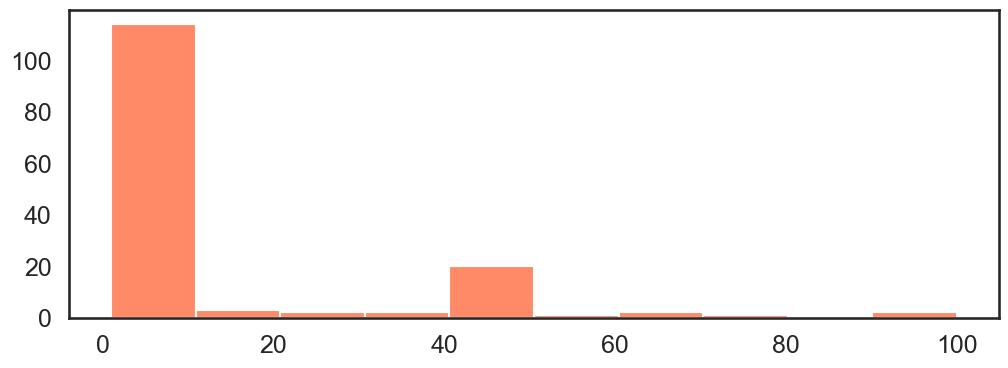

In [7]:
# Out of interest, some people aren't rating EMPTY STRING as 0..
# Indicative of attention issue, especially given there is a lump at 50 (default slider position)
empty = utterances[utterances["model_response"] == "EMPTY STRING"]
print(empty["score"].describe())
# Plot hist
plt.hist(empty["score"], bins=10)
plt.show()

## Understanding Model Rank

### Get data for manual inspection

We take any command vs gpt-4/gpt-4-turbo battles. These were manually inspected to then form some hypotheses on correlates of score.

In [8]:
# Only openers (this is where model-wise comparisons hapen)
openers = interactions[interactions["turn"] == 0]
relv_battle_rows = []
filtered_rows = []
for i, row in openers.iterrows():
    all_model_cols = ["model_name_a", "model_name_b", "model_name_c", "model_name_d"]
    # Check if command and either gpt-4 or gpt-4-turbo are in list
    command_models = ["command"]
    gpt4_models = ["gpt-4", "gpt-4-turbo"]
    indexes = {"command": None, "gpt-4": None, "gpt-4-turbo": None}
    for suffix in ["a", "b", "c", "d"]:
        col = f"model_name_{suffix}"
        if row[col] == "command":
            indexes["command"] = suffix
        for m in gpt4_models:
            if row[col] == m:
                indexes[m] = suffix

    if indexes["command"] is not None and (
        indexes["gpt-4"] is not None or indexes["gpt-4-turbo"] is not None
    ):
        filtered_rows.append(row)
        new_row = {
            "conversation_id": row["conversation_id"],
            "user_id": row["user_id"],
            "conversation_type": row["conversation_type_a"],
            "user_input": row["user_prompt"],
        }

        for model, suffix in indexes.items():
            if suffix is not None:
                new_row[f"model_response_{model}"] = row[f"model_response_{suffix}"]
                new_row[f"score_{model}"] = row[f"score_{suffix}"]
                new_row[f"if_chosen_{model}"] = row[f"if_chosen_{suffix}"]

        relv_battle_rows.append(new_row)


command_vs_gpt4 = pd.DataFrame(relv_battle_rows)
print(
    f"There are {len(command_vs_gpt4)}, across {command_vs_gpt4['user_id'].nunique()} unique users"
)


def process_winner(row):
    # Get the three scores
    scores = [row[f"score_{m}"] for m in ["command", "gpt-4", "gpt-4-turbo"]]
    # Check there aren't two spots tied for max
    if scores.count(max(scores)) > 1:
        return "tie"
    # Find the max score
    max_score = max(scores)
    # Get the index of the max score
    max_score_index = scores.index(max_score)
    # Get the model name
    winner = ["command", "gpt-4", "gpt-4-turbo"][max_score_index]
    return winner


# Assign the winner
command_vs_gpt4["WINNER"] = command_vs_gpt4.apply(process_winner, axis=1)

# Value counts
print(command_vs_gpt4["WINNER"].value_counts(normalize=True, dropna=False))

# Get n battlers
command_vs_gpt4["N_BATTLERS"] = command_vs_gpt4.apply(
    lambda x: sum(
        [
            pd.isna(x[f"model_response_{m}"]) == False
            for m in ["command", "gpt-4", "gpt-4-turbo"]
        ]
    ),
    axis=1,
)

print(command_vs_gpt4["N_BATTLERS"].value_counts(normalize=True))

command_vs_gpt4.head(2)

# Save to clipboard to transition to a manual annotation sheet
command_vs_gpt4.to_clipboard()

There are 441, across 380 unique users
WINNER
command        0.603175
gpt-4-turbo    0.188209
gpt-4          0.160998
tie            0.047619
Name: proportion, dtype: float64
N_BATTLERS
2    0.931973
3    0.068027
Name: proportion, dtype: float64


In [9]:
# Filter
filtered_df = pd.DataFrame(filtered_rows)
battles = pd.DataFrame(extract_battles(pd.DataFrame(filtered_rows), tie_thresh=5))
# Keep only battles with command and gpt-4 or gpt-4-turbo
print(f"There are {len(battles)} battles overall")
model_a = battles[
    battles["model_a"].isin(["command"])
    & battles["model_b"].isin(["gpt-4", "gpt-4-turbo"])
]
model_b = battles[
    battles["model_b"].isin(["command"])
    & battles["model_a"].isin(["gpt-4", "gpt-4-turbo"])
]
# Combine
filtered_battles = pd.concat([model_a, model_b])
print(
    f"There are {len(filtered_battles)} battles with command and gpt-4 or gpt-4-turbo"
)

# Display
filtered_battles

There are 2490 battles overall
There are 471 battles with command and gpt-4 or gpt-4-turbo


,model_a,score_a,model_b,score_b,winner
15,command,100.0,gpt-4,79.0,model_a
22,command,97.0,gpt-4-turbo,75.0,model_a
33,command,100.0,gpt-4,40.0,model_a
39,command,28.0,gpt-4,100.0,model_b
48,command,61.0,gpt-4-turbo,6.0,model_a
...,...,...,...,...,...
2464,gpt-4,86.0,command,100.0,model_b
2469,gpt-4,96.0,command,24.0,model_a
2480,gpt-4-turbo,70.0,command,81.0,model_b
2483,gpt-4-turbo,16.0,command,68.0,model_b


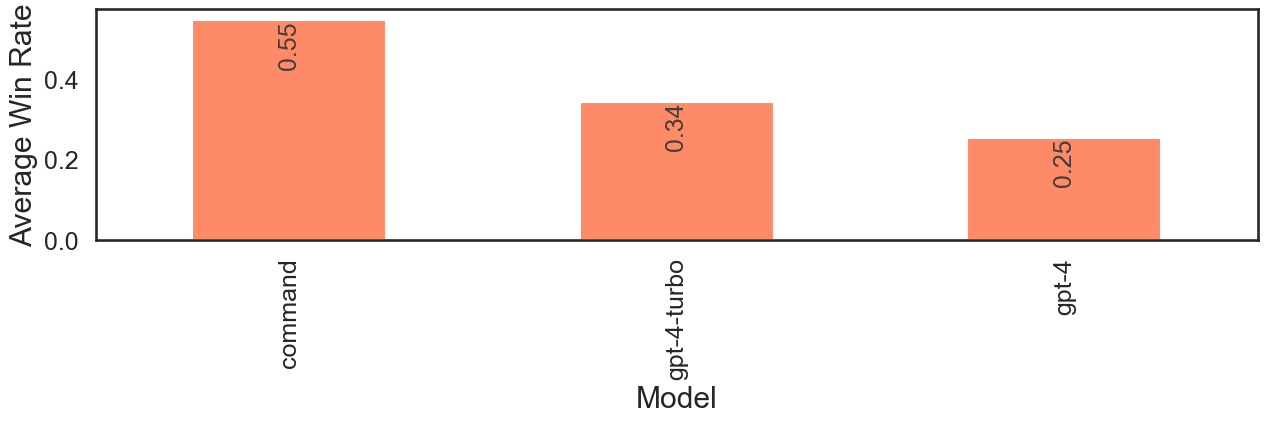

In [10]:
# Visualise
row_beats_col_freq = compute_pairwise_win_fraction(
    filtered_battles, None, limit_show_number=3
)
avg_win_rate = row_beats_col_freq.mean(axis=1).sort_values(ascending=False)
plt.figure(figsize=(15, 3))
avg_win_rate.plot(kind="bar")
for i, txt in enumerate(avg_win_rate):
    plt.annotate(
        f"{txt:.2f}",
        (i, avg_win_rate.iloc[i]),
        rotation=90,
        va="top",
        ha="center",
        color=basic_colors_dict["darkgrey"],
    )
plt.ylabel("Average Win Rate")
plt.xlabel("Model")

plt.show()

### Test Hypotheses

#### H1: Longer responses are more likely to win

In [11]:
# First a frequency analysis on response length
def calculate_response_lengths(df, suffixes):
    for suffix in suffixes:
        response_col = f"model_response{suffix}"
        length_col = f"model_response_len{suffix}"
        if response_col in df.columns:
            df[length_col] = df[response_col].apply(
                lambda x: len(x) if pd.notnull(x) else 0
            )
    return df


def longest_response_chosen_frequency(df, suffixes):
    def is_longest_chosen(row):
        lengths = [
            row[f"model_response_len{suffix}"]
            for suffix in suffixes
            if f"model_response_len{suffix}" in row
        ]
        chosen_lengths = [
            (
                row[f"model_response_len{suffix}"]
                if row.get(f"if_chosen{suffix}", False)
                else 0
            )
            for suffix in suffixes
        ]
        return max(chosen_lengths) == max(lengths) if max(lengths) > 0 else False

    df["longest_chosen"] = df.apply(is_longest_chosen, axis=1)
    return df["longest_chosen"].mean()


# Set up code so we can run these tests as narrow (only command/gpt-4) or wide (all models)
cvsgpt = {"suffixes": ["_command", "_gpt-4", "_gpt-4-turbo"], "df": command_vs_gpt4}
all = {"suffixes": ["_a", "_b", "_c", "_d"], "df": interactions}

for test in [cvsgpt, all]:
    df = calculate_response_lengths(test["df"], test["suffixes"])
    longest_chosen_freq = longest_response_chosen_frequency(df, test["suffixes"])
    print(
        f"Frequency of longest responses being chosen {test['suffixes']}: {longest_chosen_freq:.2%}"
    )

Frequency of longest responses being chosen ['_command', '_gpt-4', '_gpt-4-turbo']: 47.17%
Frequency of longest responses being chosen ['_a', '_b', '_c', '_d']: 51.90%


#### Set up OLS

count     912.000000
mean      620.367325
std       418.222463
min        34.000000
25%       301.750000
50%       372.000000
75%       960.250000
max      1618.000000
Name: num_chars, dtype: float64
                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     25.24
Date:                Tue, 23 Apr 2024   Prob (F-statistic):           6.20e-07
Time:                        17:21:12   Log-Likelihood:                -3934.1
No. Observations:                 841   AIC:                             7872.
Df Residuals:                     839   BIC:                             7882.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
          

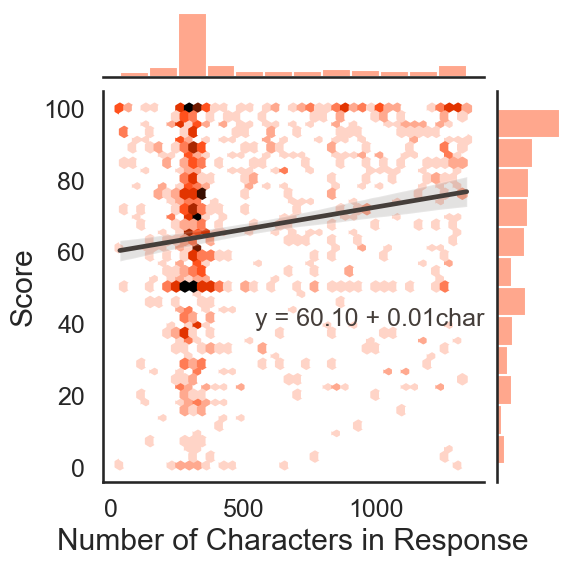

count    68371.000000
mean       565.298986
std        387.896664
min          1.000000
25%        294.000000
50%        448.000000
75%        807.000000
max       4630.000000
Name: num_chars, dtype: float64
                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     1774.
Date:                Tue, 23 Apr 2024   Prob (F-statistic):               0.00
Time:                        17:21:12   Log-Likelihood:            -3.1120e+05
No. Observations:               64952   AIC:                         6.224e+05
Df Residuals:                   64950   BIC:                         6.224e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
  

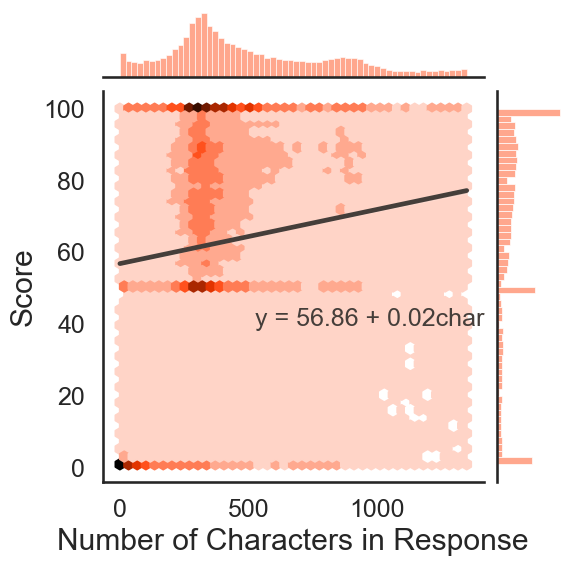

In [12]:
# OLS
def prep_reg_data(df, suffixes):
    regression_data = pd.DataFrame()
    for suffix in suffixes:
        # Check if the necessary columns exist
        response_col = f"model_response_len{suffix}"
        score_col = f"score{suffix}"

        if response_col in df.columns and score_col in df.columns:
            # Prepare a temp df for this suffix/model type
            temp_df = df[
                [response_col, score_col]
            ].dropna()  # Drop rows with NaNs in these columns
            temp_df = temp_df.rename(
                columns={response_col: "num_chars", score_col: "score"}
            )

            # Append the data for this model to the main regression DataFrame
            regression_data = pd.concat([regression_data, temp_df])

    # Find 95th percentile of response lengths (remove any above)
    print(regression_data["num_chars"].describe())
    regression_data = regression_data[regression_data["num_chars"] < length_95]

    return regression_data


def perform_regression(regression_data, print_summary=True, save_name=None):
    # Add a constant term to the predictor for the intercept
    X = sm.add_constant(regression_data["num_chars"])
    Y = regression_data["score"]

    model = sm.OLS(Y, X).fit()
    if print_summary:
        print(model.summary())

    # Joint plot
    reg_color = basic_colors_dict["darkgrey"]
    g = sns.jointplot(
        x=regression_data["num_chars"],
        y=regression_data["score"],
        kind="hex",
        palette=palettes_dict["roma"],
        joint_kws={"gridsize": 40, "bins": 10},
    )
    sns.regplot(
        x=regression_data["num_chars"],
        y=regression_data["score"],
        ax=g.ax_joint,
        scatter=False,
        color=reg_color,
    )
    # Add text for params
    ax = g.ax_joint
    ax.text(
        0.4,
        0.4,
        f"y = {model.params['const']:.2f} + {model.params['num_chars']:.2f}char",
        transform=ax.transAxes,
        color=reg_color,
    )
    ax.set_xlabel("Number of Characters in Response")
    ax.set_ylabel("Score")

    # Save
    if save_name:
        plt.savefig(f"{PLOT_PATH}/{save_name}.pdf", bbox_inches="tight", format="pdf")
    plt.show()


for test, name in zip([cvsgpt, all], [None, "hypothesis_length_models"]):
    regression_data = prep_reg_data(test["df"], test["suffixes"])
    perform_regression(regression_data, save_name=name)

#### Create data store


In [13]:
# Calculate the number of line breaks for each response
target_models = ["gpt-4", "gpt-4-turbo", "command"]
openers = utterances[utterances["turn"] == 0]
full_df = openers.copy()
sub_df = openers[openers["model_name"].isin(target_models)]

# Create a data store
data = {}
data["full_data"] = full_df
data["reduced_data"] = sub_df

#### H2-4: Formatting Matters

H2 = Line Breaks

H3 = Question Marks

H4 = Enumerations

In [14]:
def contains_enumeration(text):
    # Pattern for numbered list, e.g., "1.", "2.", "3."
    numbered_list_pattern = re.compile(r"\n\s*\d+\.\s+")

    # Pattern for bulleted list, e.g., "-", " -", "* ", " * ", etc.
    bulleted_list_pattern = re.compile(r"\n\s*[-*]\s+")

    # Check if patterns are found in the text
    if re.search(numbered_list_pattern, text) or re.search(bulleted_list_pattern, text):
        return True
    else:
        return False

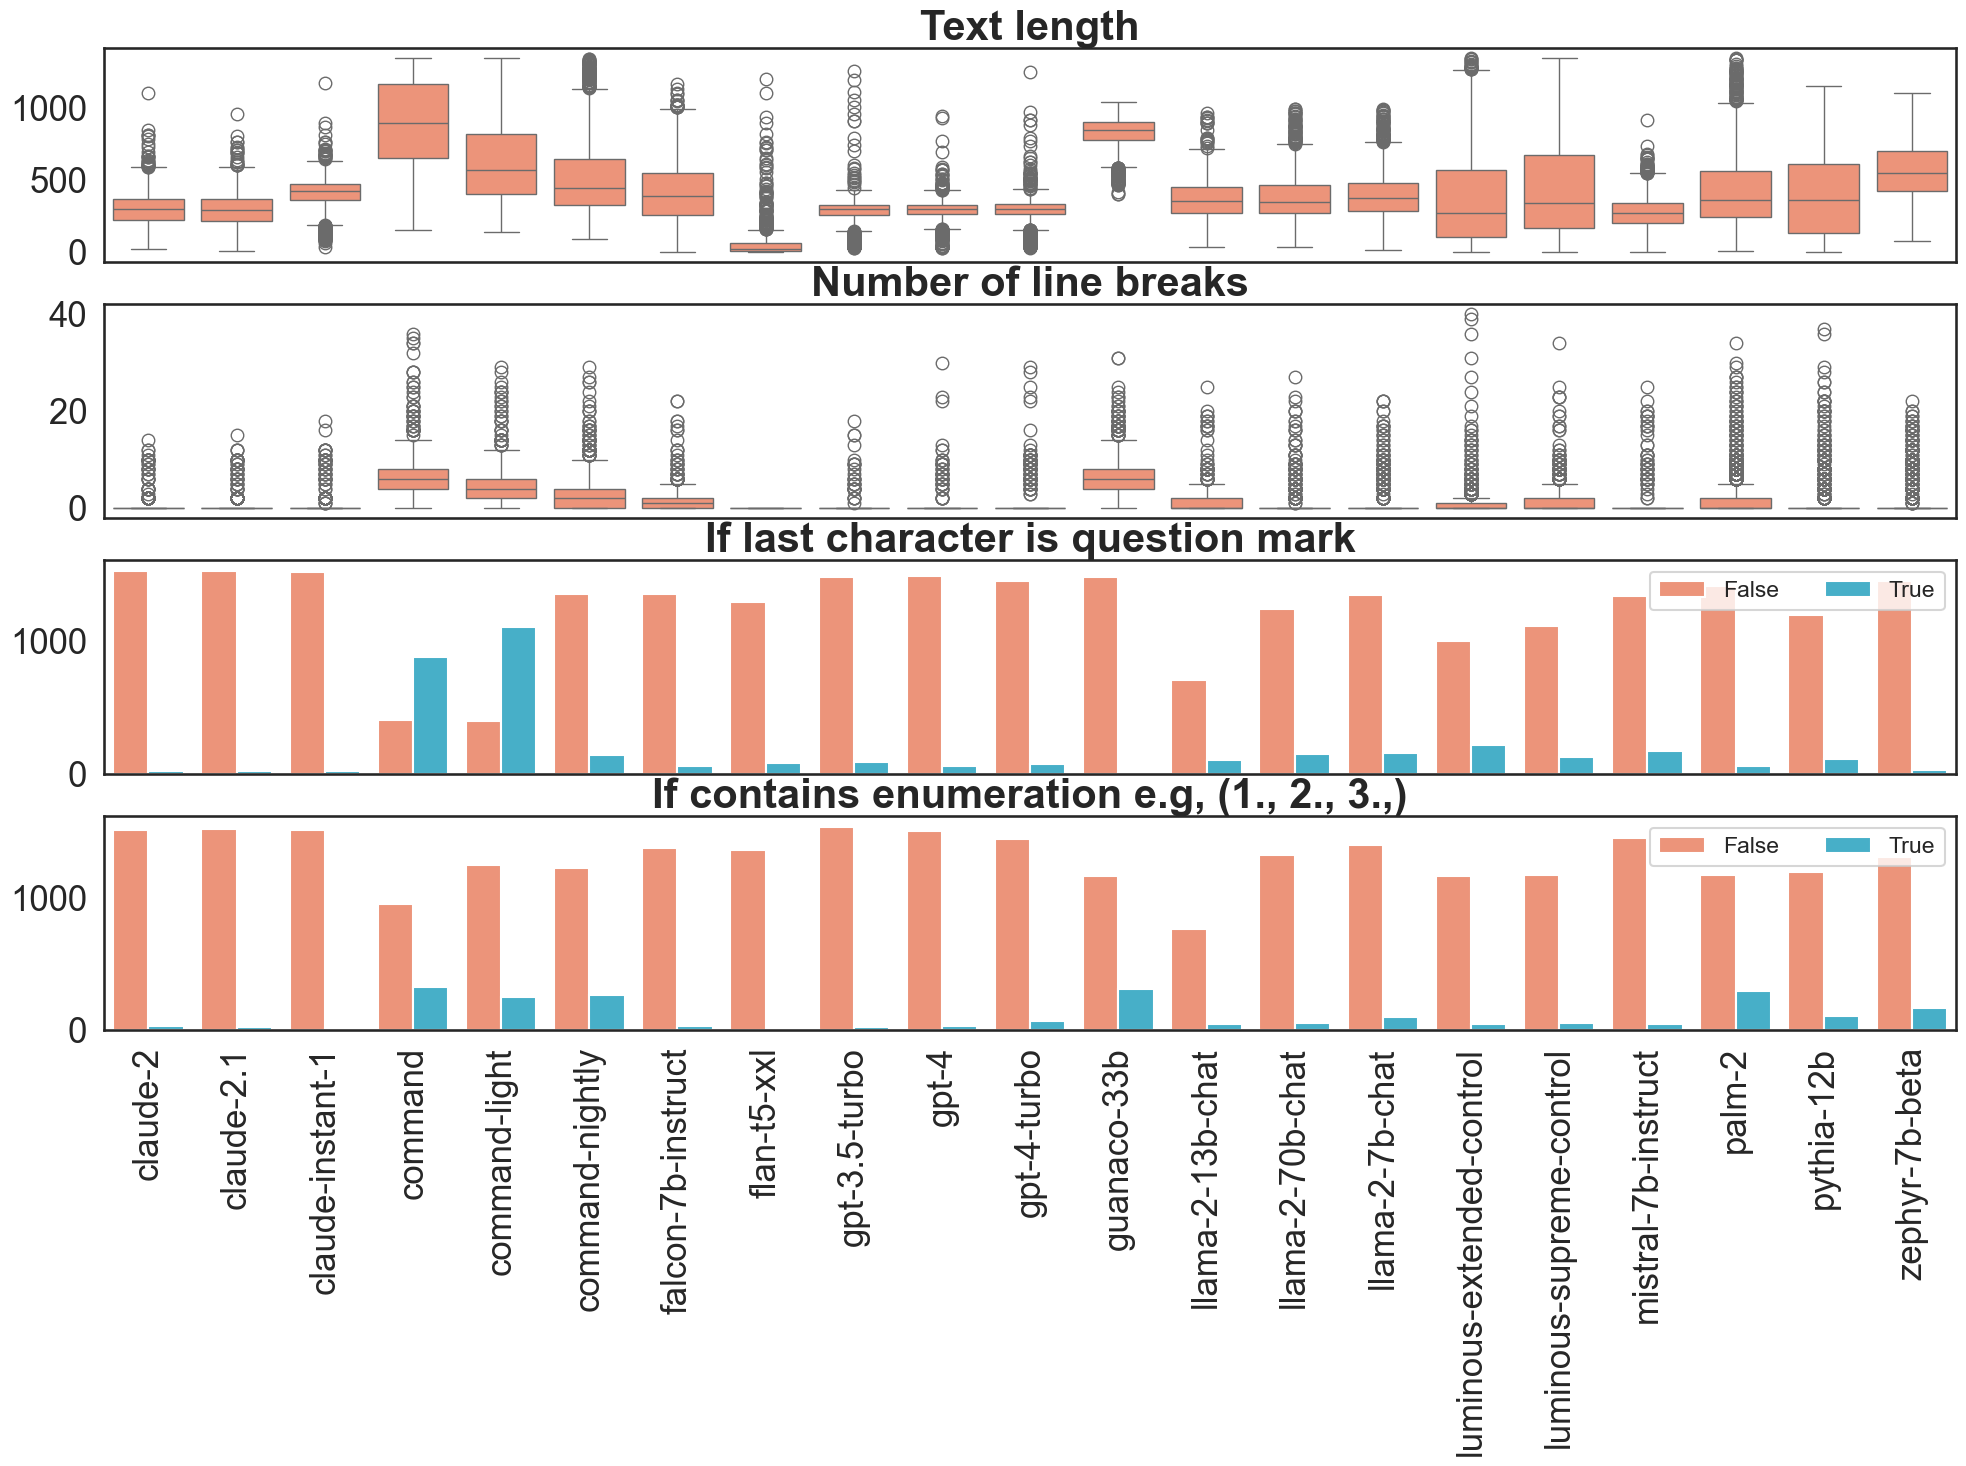

text_length          int64
if_line_breaks        bool
if_question_marks     bool
if_enumeration        bool
dtype: object
                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     398.9
Date:                Tue, 23 Apr 2024   Prob (F-statistic):               0.00
Time:                        17:21:16   Log-Likelihood:            -1.4364e+05
No. Observations:               29706   AIC:                         2.873e+05
Df Residuals:                   29701   BIC:                         2.873e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--

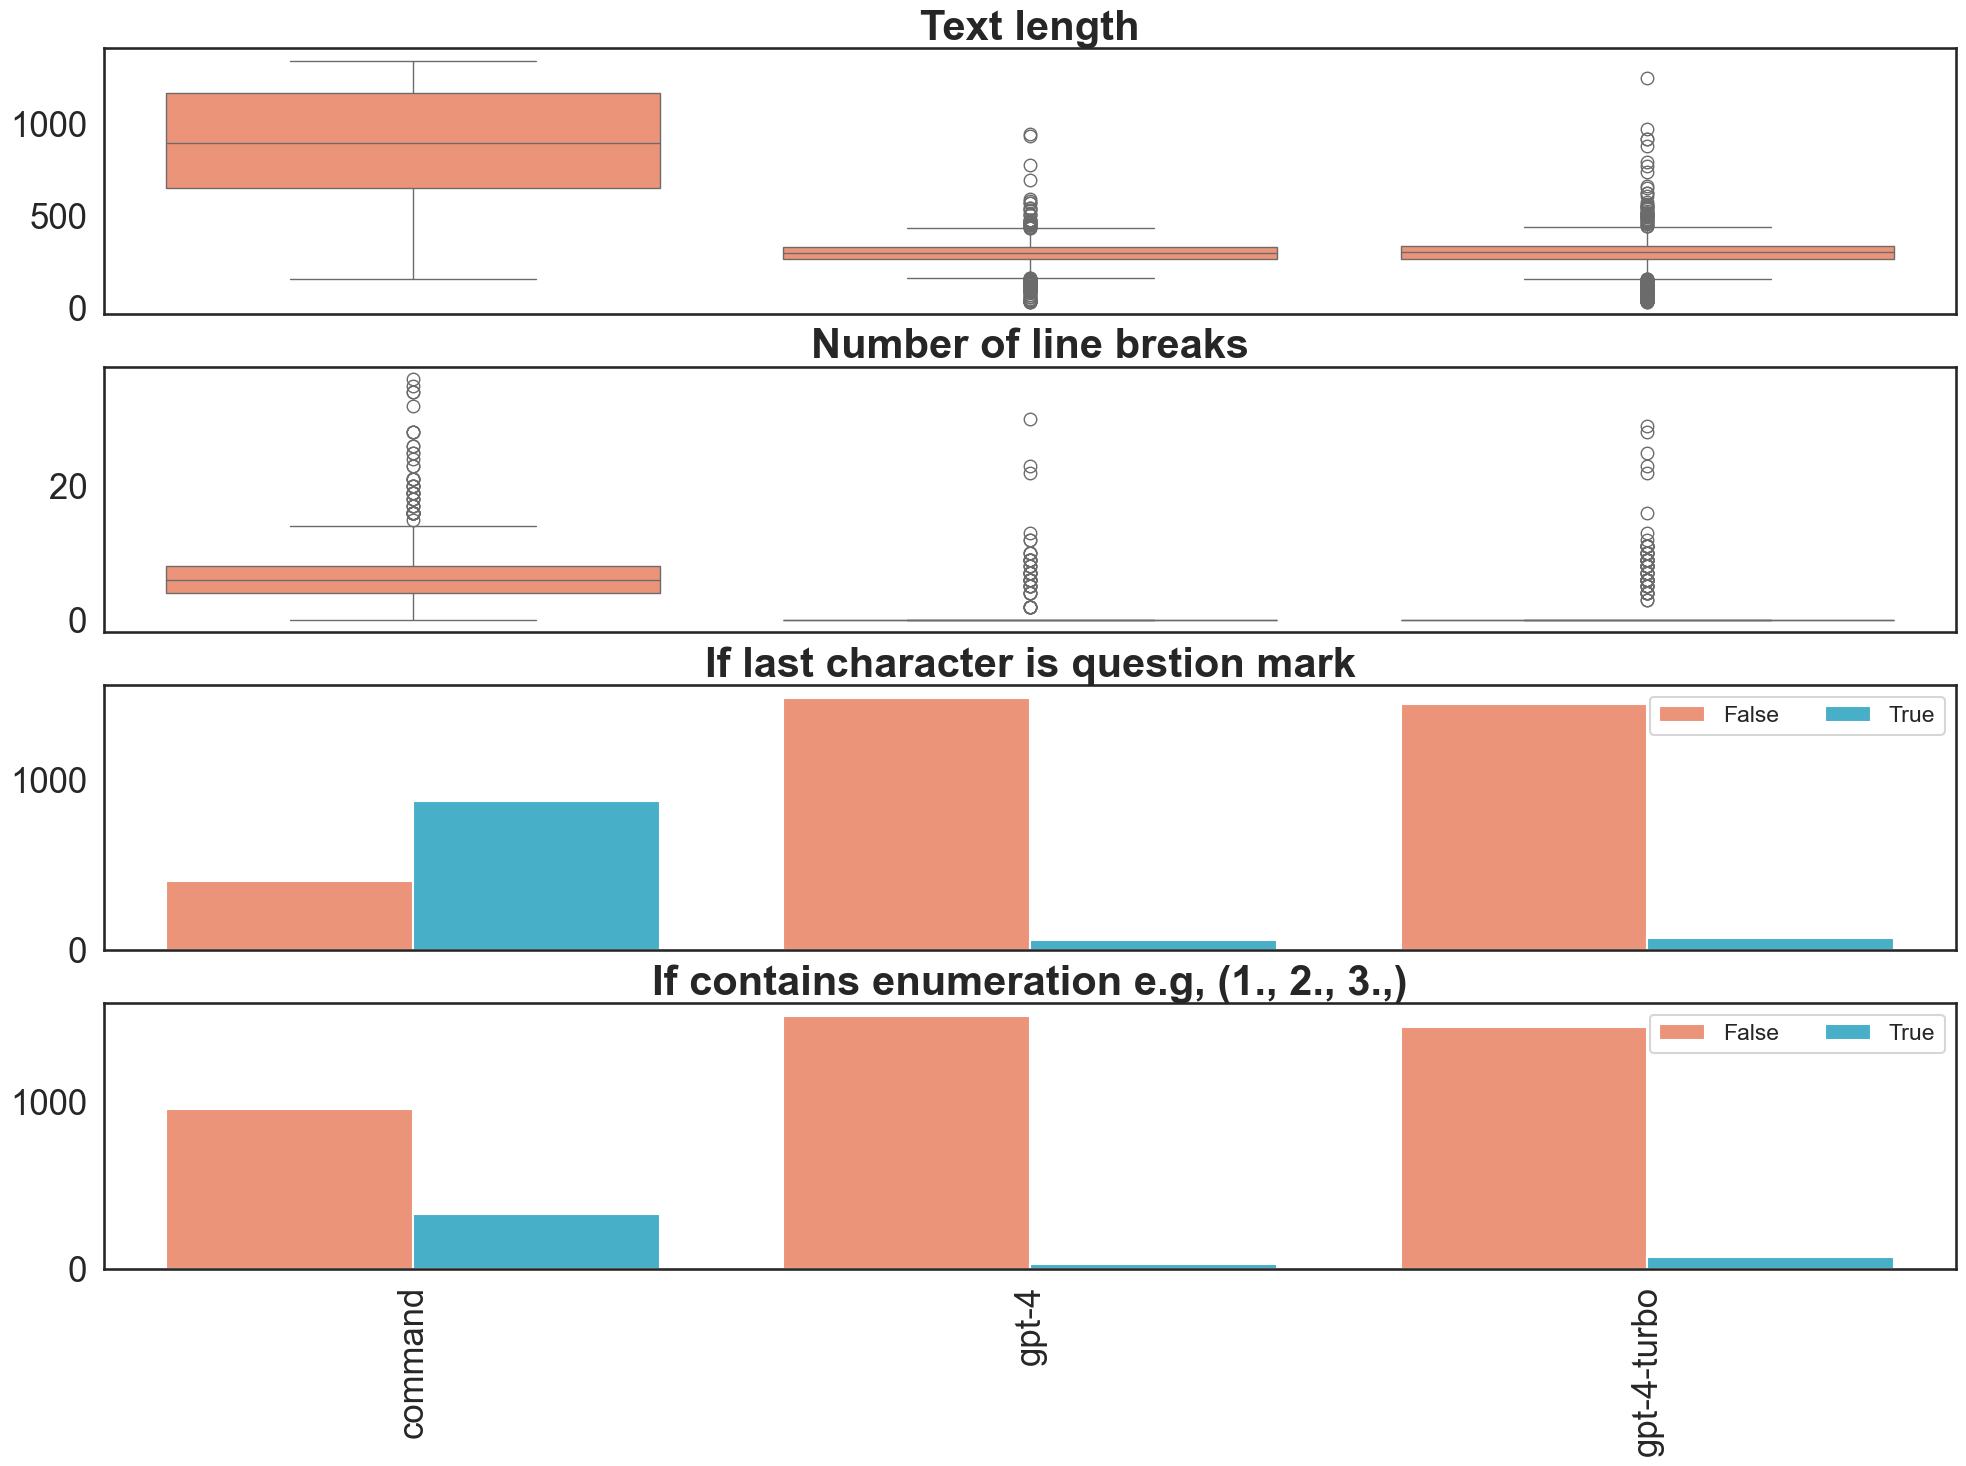

text_length          int64
if_line_breaks        bool
if_question_marks     bool
if_enumeration        bool
dtype: object
                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     23.17
Date:                Tue, 23 Apr 2024   Prob (F-statistic):           5.63e-19
Time:                        17:21:16   Log-Likelihood:                -20325.
No. Observations:                4349   AIC:                         4.066e+04
Df Residuals:                    4344   BIC:                         4.069e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--

In [15]:
for key, df in data.items():
    df = df.copy()
    # H1 = LENGTH
    df["text_length"] = df["model_response"].apply(
        lambda x: len(x) if pd.notnull(x) else 0
    )
    # H2 = LINE BREAKS
    df["line_breaks"] = df["model_response"].apply(
        lambda x: x.count("\n") if pd.notnull(x) else 0
    )
    df["if_line_breaks"] = df["model_response"].apply(
        lambda x: "\n" in x if pd.notnull(x) else False
    )
    # H3 = QUESTION MARKS
    df["question_marks"] = df["model_response"].apply(
        lambda x: x.count("?") if pd.notnull(x) else 0
    )
    df["if_question_marks"] = df["model_response"].apply(
        lambda x: x[-1] == "?" if pd.notnull(x) else False
    )
    # H4 = ENUMERATION
    df["if_enumeration"] = df["model_response"].apply(contains_enumeration)

    # Cutoff for text length (remove outliers)
    df_red = df[df["text_length"] < length_95]
    # Sort df by model name
    avg_score = df_red.groupby("model_name")["score"].mean()
    # Get model order
    model_order = avg_score.sort_values(ascending=False).index
    # Sort df by this model order
    df_red = df_red.copy()
    df_red["model_name"] = pd.Categorical(
        df_red["model_name"], categories=model_order, ordered=True
    )

    # Plot number of line_breaks by model_name
    cols = ["text_length", "line_breaks", "if_question_marks", "if_enumeration"]
    titles = [
        "Text length",
        "Number of line breaks",
        "If last character is question mark",
        "If contains enumeration e.g, (1., 2., 3.,)",
    ]
    if key == "reduced_data":
        save_name = None
    else:
        save_name = "hypothesis_format_models"
    plot_multibox(df_red, cols, titles, figsize=(20, 15), save_name=save_name)

    # Run a regression
    df_reg = df_red.copy()
    bool_vars = ["if_line_breaks", "if_question_marks", "if_enumeration"]
    for col in bool_vars:
        df_reg[col] = df_reg[col].astype(int)
    x_vars = ["text_length"] + bool_vars
    # Check the dtypes
    print(df[x_vars].dtypes)
    y_var = "score"
    # Prepare data
    df_reg = df_reg[[y_var] + x_vars]
    df_reg = df_reg.dropna()
    # Specify the model
    X = sm.add_constant(df_reg[x_vars])
    y = df_reg[y_var]
    model = sm.OLS(y, X).fit()
    print(model.summary())

    # Update the data
    data[key] = df

### H3-H6: Phrases

These phrases are seeded from previous work and from manual inspection of the data. More formal work in the future could expand these lists, or find a more principled way to include phrases from templated responses (aka always include _do not_ and _don't_ versions). It is enough for now for now to test our initial hypotheses.

In [16]:
deanthro_phrases = [
    "I don't have personal",
    "I do not have personal",
    "I am a chatbot",
    "I'm a large language model",
    "As an artificial intelligence language model",
    "As an AI language model ",
    "I cannot express",
    "I can't express",
    "I do not hold personal",
    "I don't hold personal",
    "As an artificial intelligence",
    "I don't hold",
    "As an AI",
    "as a conversational assistant",
    "I am an AI assistant",
    "as an AI chatbot",
    "I am a language model",
    "I do not have feelings",
    "I don't have feelings",
    "I am trained",
    "I'm just an AI",
]

refusal_phrases = [
    "I'm sorry, but",
    "I'm sorry, but",
    "I'm not able",
    "it is not appropriate",
    "it's not appropriate",
    "it is not accurate",
    "it's not accurate",
    "i am not sure that it's appropriate",
    "i'm not sure that it's appropriate",
    "it is not ethical",
    "it's not ethical",
    "I am sorry, I cannot help with",
    "I cannot answer that question",
    "I'm unable",
    "I am unable to answer",
    "I'm sorry, I cannot give an opinion",
    "I can't help you with that request",
    "I cannot provide",
    "I can't engage in that conversation",
    "I cannot take sides",
    "I cannot give",
    "I cannot engage",
    "I am not able to answer",
    "I cannot provide information",
    "I cannot endorse",
    "I cannot provide",
    "I cannot produce",
    "I apologize, but",
    "I apologise, but",
]

self_identification_phrases = [
    "Google",
    "Cohere",
    "OpenAI",
    "Aleph Alpha",
    "Anthropic",
    "Meta",
    "HuggingFace",
    "Coral",
] + model_name_table["short_name"].map(lambda x: x.split("-")[0]).unique().tolist()

% with Deanthro phrase: 0.11041964790841625
% with Refusal phrase: 0.033179140736796564
% with Self-Identification phrase: 0.03048354354554228


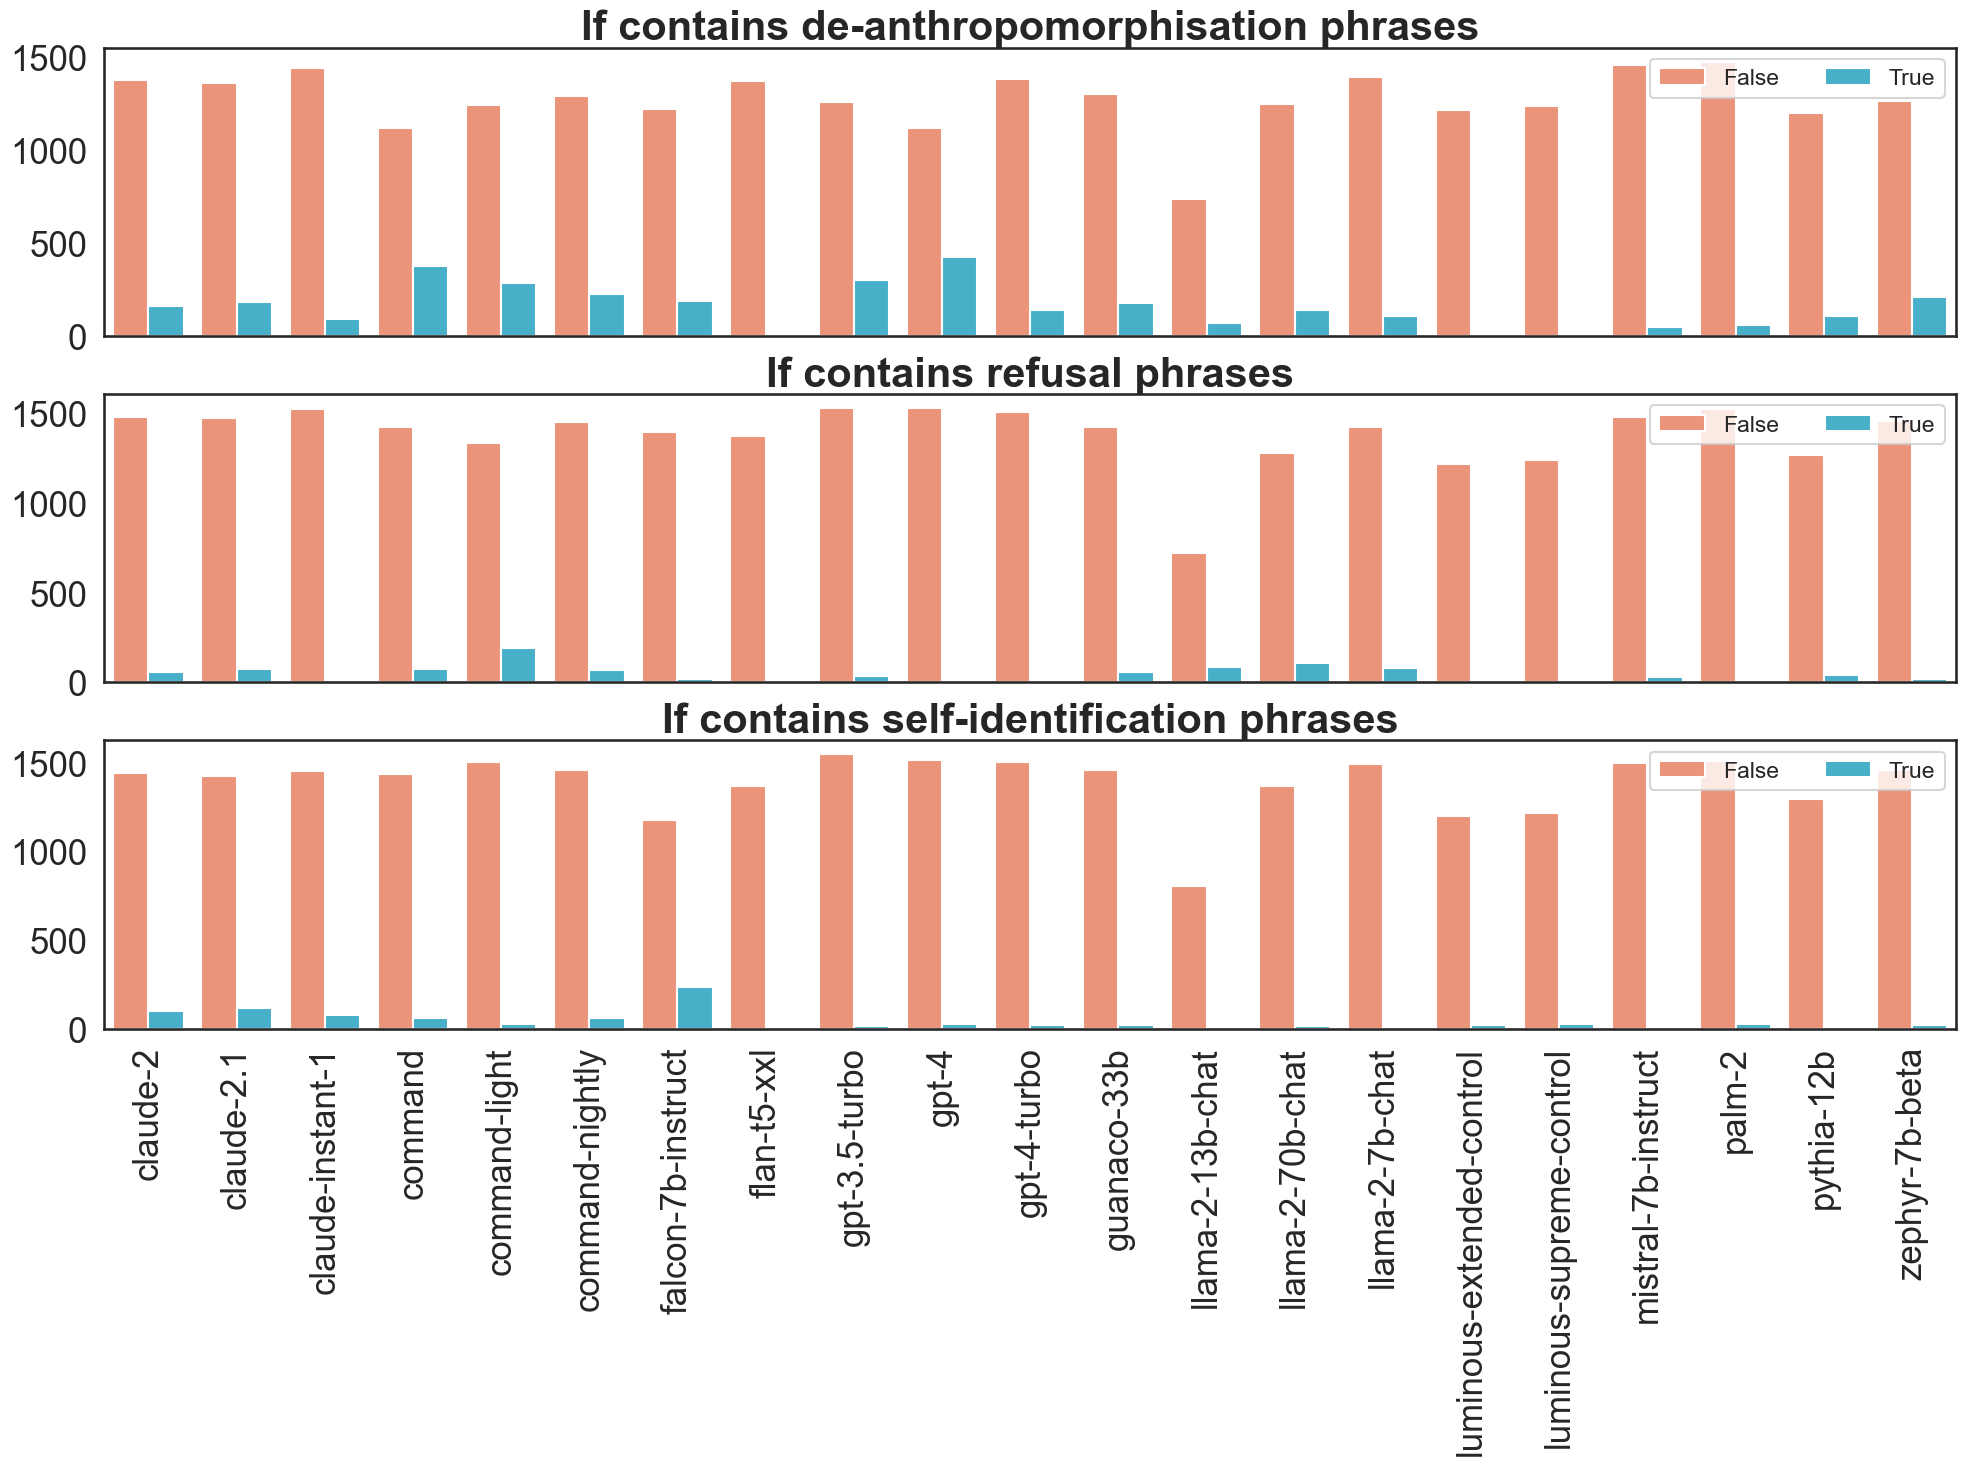

% with Deanthro phrase: 0.20626918018412976
% with Refusal phrase: 0.02257781674704077
% with Self-Identification phrase: 0.023235423060061378


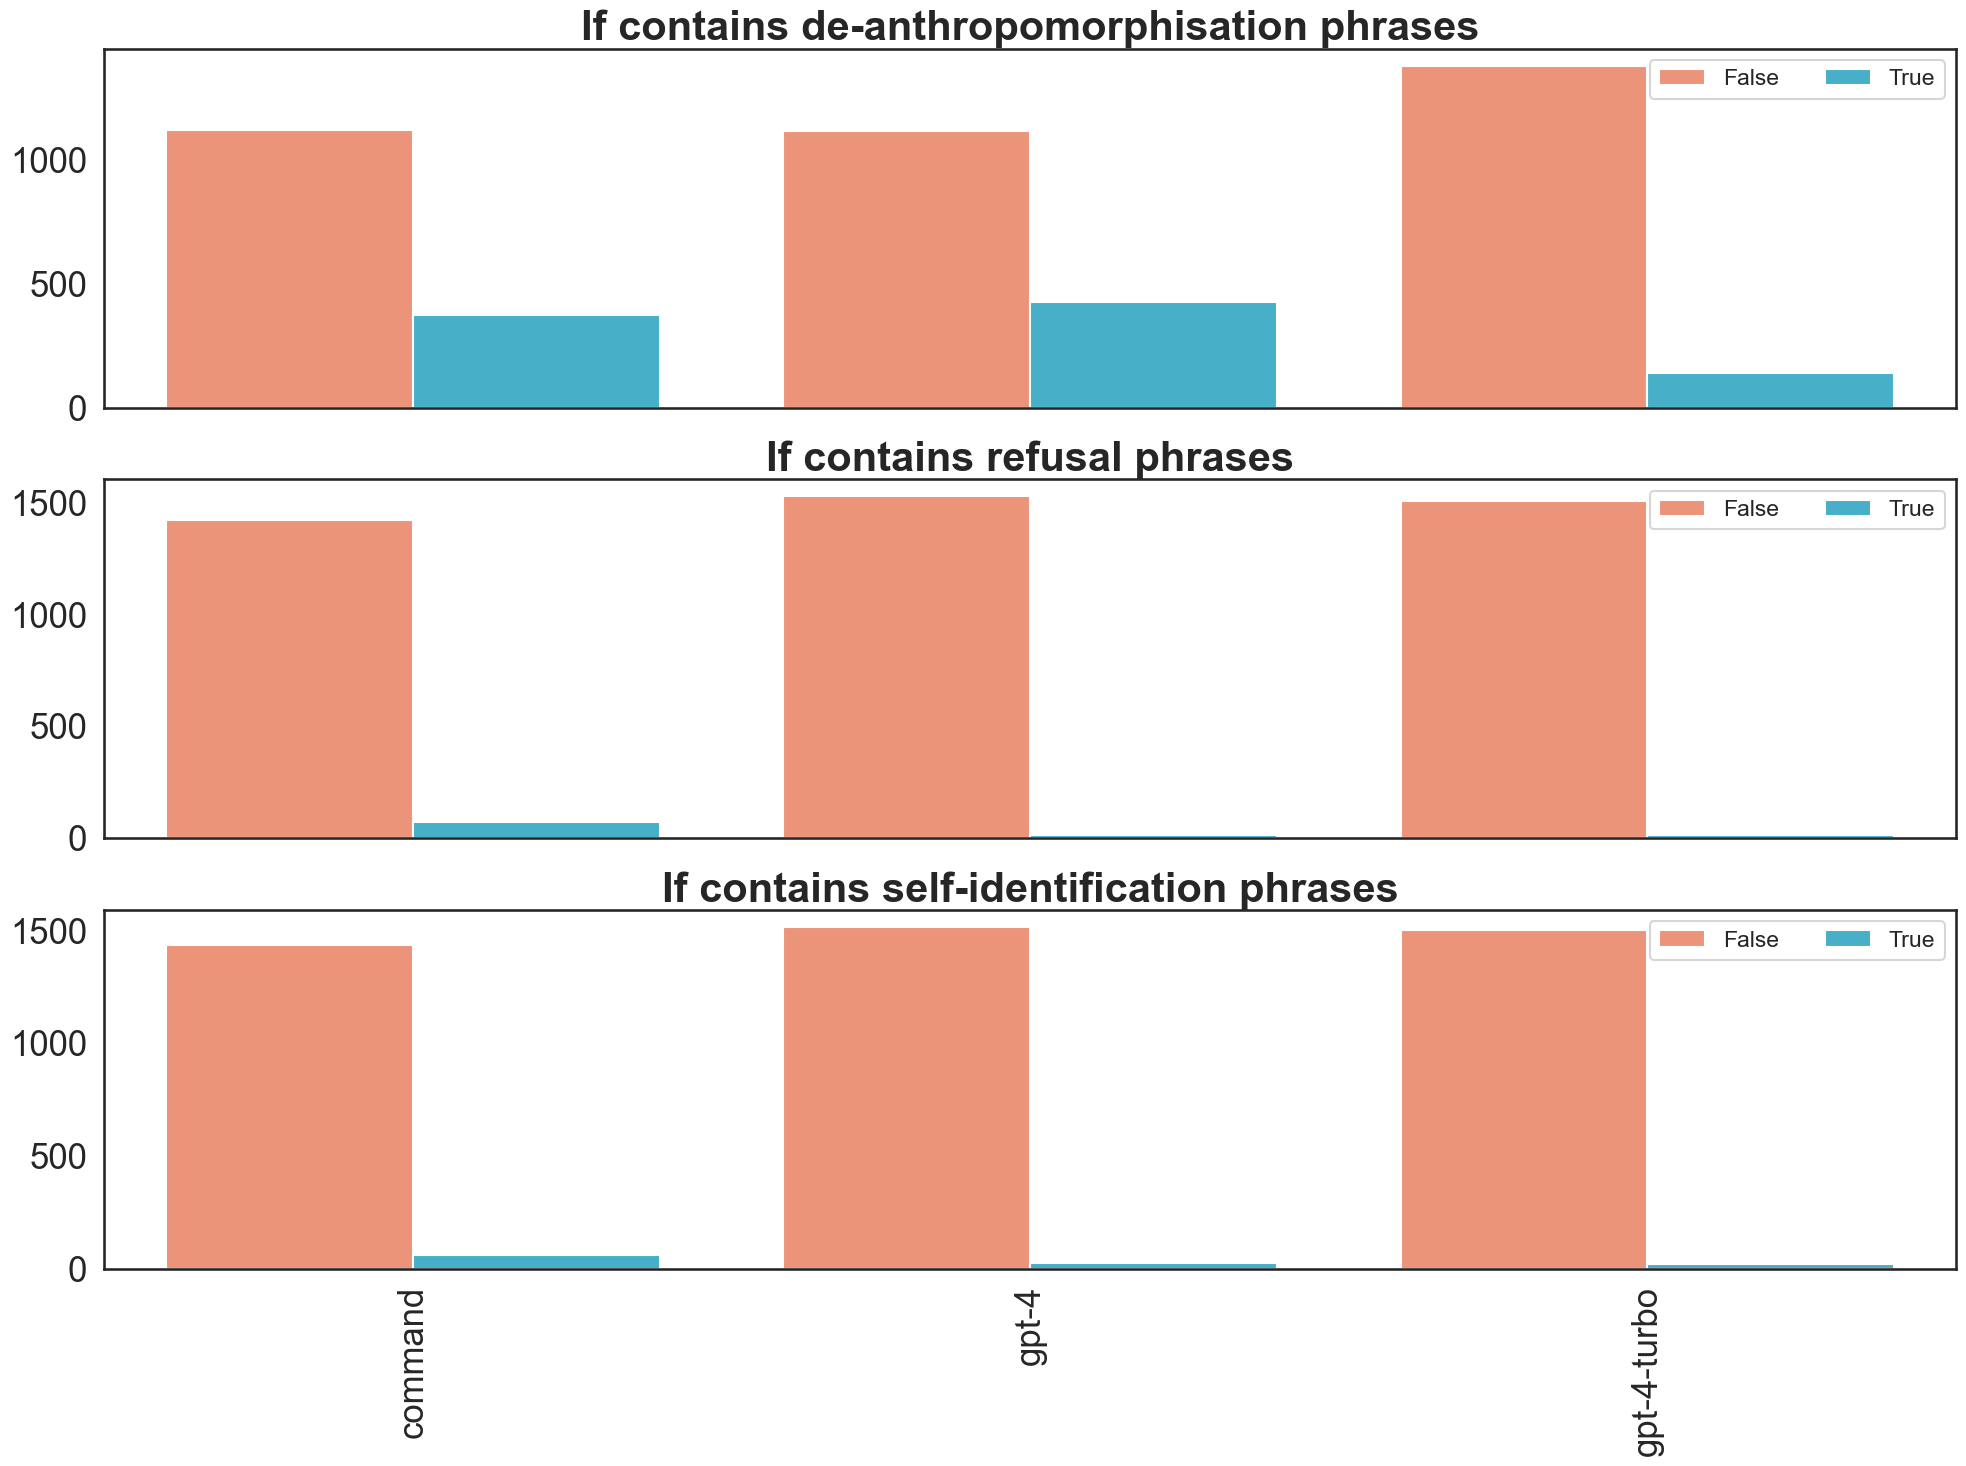

In [17]:
def contains_phrase(text, phrases):
    # Create a regex pattern that matches any of the phrases
    pattern = re.compile(
        "|".join(re.escape(phrase) for phrase in phrases), re.IGNORECASE
    )

    # Search for the pattern in the text
    if re.search(pattern, text):
        return True
    else:
        return False


for key, df in data.items():
    df = df.copy()
    # Apply the function to each row of the DataFrame for different checks
    df["if_deanthro"] = df["model_response"].apply(
        lambda x: contains_phrase(x, deanthro_phrases)
    )
    df["if_refusal"] = df["model_response"].apply(
        lambda x: contains_phrase(x, refusal_phrases)
    )

    df["if_self_identification"] = df["model_response"].apply(
        lambda x: contains_phrase(x, self_identification_phrases)
    )
    # Summarise
    print("% with Deanthro phrase:", df["if_deanthro"].mean())
    print("% with Refusal phrase:", df["if_refusal"].mean())
    print("% with Self-Identification phrase:", df["if_self_identification"].mean())

    # Plot
    cols = ["if_deanthro", "if_refusal", "if_self_identification"]
    titles = [
        "If contains de-anthropomorphisation phrases",
        "If contains refusal phrases",
        "If contains self-identification phrases",
    ]
    if key == "reduced_data":
        save_name = None
    else:
        save_name = "hypothesis_phrases_models"
    plot_multibox(df, cols, titles, figsize=(20, 15), save_name=save_name)

    # Update the data
    data[key] = df

In [18]:
# Check frequency of if model refuses to answer how often it loses to a model that does not refuse
openers = interactions[interactions["turn"] == 0]
for suffix in ["a", "b", "c", "d"]:
    openers = openers.copy()
    openers[f"if_refusal_{suffix}"] = openers[f"model_response_{suffix}"].apply(
        lambda x: contains_phrase(x, refusal_phrases) if pd.isna(x) == False else np.nan
    )

In [19]:
def check_if_refuser_wins(row):
    if_chosens = [row[f"if_chosen_{suffix}"] for suffix in ["a", "b", "c", "d"]]
    if_refusers = [row[f"if_refusal_{suffix}"] for suffix in ["a", "b", "c", "d"]]

    chosen_index = if_chosens.index(
        True
    )  # Get the index of the chosen one, assuming only one can be True
    chosen_is_refuser = if_refusers[
        chosen_index
    ]  # Check if the chosen one is a refuser

    # Count the total number of refusers
    total_refusers = sum(if_refusers)

    # Check conditions
    if (total_refusers == 0) or pd.isna(total_refusers):
        return "no refusers"
    elif chosen_is_refuser and total_refusers == 1:
        return "refuser chosen (in company of no other refusers)"
    elif chosen_is_refuser and total_refusers > 1:
        return "refuser chosen (in company of at least one other refuser)"
    elif chosen_is_refuser == False and total_refusers > 0:
        return "non-refuser chosen"
    else:
        return "other"


openers["refuser_outcome"] = openers.apply(check_if_refuser_wins, axis=1)
print(f"\nAll counts from {len(openers)} prompts:")

print(openers["refuser_outcome"].value_counts(normalize=True, dropna=False))
# Now get pct of values (dropping no refusers)
print("\nWhen there is at least one refuser:")
vcs = openers["refuser_outcome"].value_counts(normalize=False, dropna=False)
vcs = vcs.drop("no refusers")
print(vcs / vcs.sum())


All counts from 8011 prompts:
refuser_outcome
no refusers                                                  0.916989
non-refuser chosen                                           0.060417
refuser chosen (in company of no other refusers)             0.015479
refuser chosen (in company of at least one other refuser)    0.007115
Name: proportion, dtype: float64

When there is at least one refuser:
refuser_outcome
non-refuser chosen                                           0.727820
refuser chosen (in company of no other refusers)             0.186466
refuser chosen (in company of at least one other refuser)    0.085714
Name: count, dtype: float64


### Putting it Together

In [20]:
df_reg = data["full_data"]
bool_vars = [
    "if_line_breaks",
    "if_question_marks",
    "if_enumeration",
    "if_deanthro",
    "if_refusal",
    "if_self_identification",
]
x_vars = ["text_length"] + bool_vars
# Check the dtypes
print(df_reg[x_vars].dtypes)
# Convert bools to numeric
for col in bool_vars:
    df_reg[col] = df_reg[col].astype(int)
y_var = "score"
# Prepare data
df_reg = df_reg[[y_var] + x_vars]
df_reg = df_reg.dropna()
# Specify the model
X = sm.add_constant(df_reg[x_vars])
y = df_reg[y_var]
model = sm.OLS(y, X).fit()
print(model.summary())
print(model.summary().as_latex())

text_length               int64
if_line_breaks             bool
if_question_marks          bool
if_enumeration             bool
if_deanthro                bool
if_refusal                 bool
if_self_identification     bool
dtype: object
                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     253.6
Date:                Tue, 23 Apr 2024   Prob (F-statistic):               0.00
Time:                        17:21:34   Log-Likelihood:            -1.4521e+05
No. Observations:               30049   AIC:                         2.904e+05
Df Residuals:                   30041   BIC:                         2.905e+05
Df Model:                           7                                         
Covariance Type:            nonrobust              

### Check Multicolinearity
Condition number is large

<Axes: >

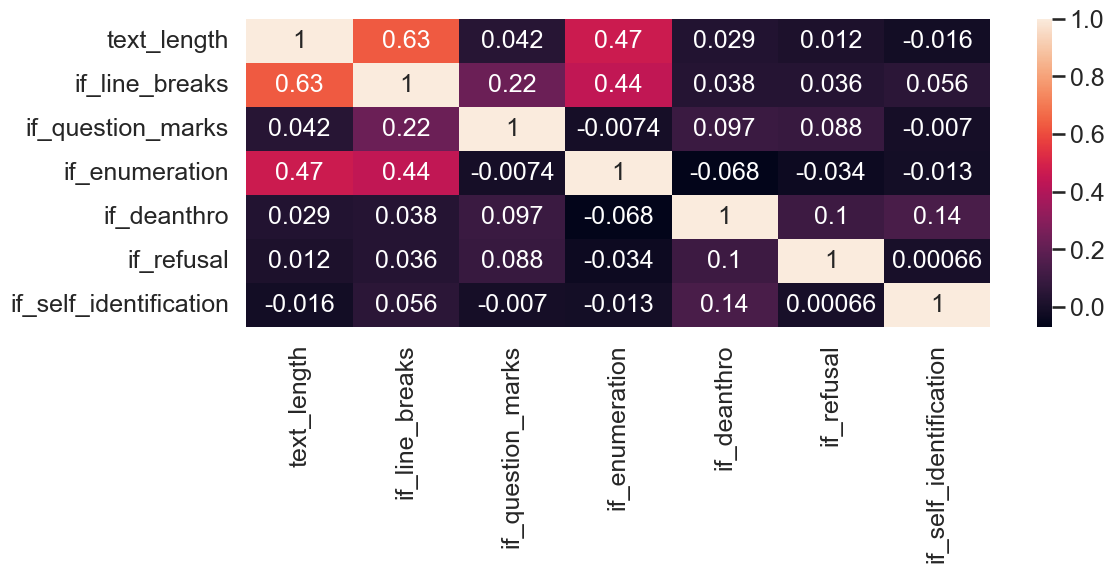

In [21]:
# Check correlation between x var ()
sns.heatmap(df_reg[x_vars].corr(), annot=True)